# KALM Severity Comparison Analysis

This notebook analyzes how different security scanners assign severity levels to the same security issues, providing insights into:

- **Severity consistency** across scanners for identical vulnerabilities
- **Scanner-specific severity patterns** and rating philosophies  
- **Coverage gaps** where scanners miss severity information
- **Severity distribution analysis** across security categories
- **Practical recommendations** for interpreting multi-scanner results

**Goal**: Understand how severity ratings vary across scanners and identify the most reliable severity sources for different vulnerability types.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from pathlib import Path
import warnings

# KALM imports
from kalm_benchmark.evaluation.evaluation import load_benchmark, Col
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("viridis")

print("🔍 KALM Severity Comparison Analysis - Initializing...")

b'\x1b\x1b!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\x1b\x1b\n'
b'\x1b\x1b!!                                                                                                                      !!\x1b\x1b\n'
b'\x1b\x1b!!  This software has not been tested with node v24.5.0.                                                                !!\x1b\x1b\n'
b'\x1b\x1b!!  Should you encounter odd runtime issues, please try using one of the supported release before filing a bug report.  !!\x1b\x1b\n'
b'\x1b\x1b!!                                                                                                                      !!\x1b\x1b\n'
b'\x1b\x1b!!  This software is currently running on node v24.5.0.                                                                 !!\x1b\x1b\n'
b'\x1b\x1b!!  As of the current release of this software, supported node releases are:                                            !!\x1b

🔍 KALM Severity Comparison Analysis - Initializing...


## 1. Data Loading and Preprocessing

Load scanner results and benchmark data, then normalize severity formats across scanners.

In [3]:
# Load benchmark data for context
df_bench = load_benchmark(with_categories=True)

# Connect to database and load scanner results with severity info
db_path = Path('../data/kalm.db')

if not db_path.exists():
    print("❌ Database not found. Run scanners first using: poetry run cli scan <scanner> -f manifests")
    df_results = pd.DataFrame()  # Empty dataframe for demo
else:
    with sqlite3.connect(db_path) as conn:
        # Load all scanner results with severity information
        df_results = pd.read_sql_query("""
            SELECT 
                scanner_name,
                scanner_check_id,
                scanner_check_name,
                obj_name,
                kind,
                namespace,
                severity,
                got as status,
                scan_timestamp
            FROM scanner_results 
            WHERE severity IS NOT NULL AND severity <> ''
            ORDER BY scanner_name, scanner_check_id
        """, conn)
        
        print(f"📊 Loaded {len(df_results):,} scanner results with severity data")
        print(f"📊 Covering {df_results['scanner_name'].nunique()} scanners")
        print(f"📊 Across {df_results['scanner_check_id'].nunique()} unique scanner checks")

📊 Loaded 14,731 scanner results with severity data
📊 Covering 11 scanners
📊 Across 363 unique scanner checks


In [4]:
if len(df_results) > 0:
    # Scanner-specific severity normalization mapping
    SEVERITY_MAPPING = {
        'CRITICAL': 5, 'Critical (1)': 5, 'critical': 5,
        'HIGH': 4, 'High': 4, 'high': 4, 'danger': 4,
        'MEDIUM': 3, 'Medium': 3, 'medium': 3, 'Warning (5)': 3, 'warning': 3,
        'LOW': 2, 'Low': 2, 'low': 2, 'INFO': 1, 'Info': 1,
        'Ok (10)': 0, 'Skipped (0)': 0,  # Special cases
        '3': 4, '2': 3, '1': 2, '0': 1  # Numeric severity (kubesec, etc)
    }
    
    def normalize_severity(severity: str) -> tuple:
        """Convert scanner-specific severity to normalized scale and category"""
        if pd.isna(severity) or severity == '':
            return None, None
            
        numeric_severity = SEVERITY_MAPPING.get(severity, None)
        
        if numeric_severity is None:
            # Handle unmapped severities
            return None, f"unmapped:{severity}"
        
        # Map numeric to category
        severity_categories = {
            5: 'CRITICAL', 4: 'HIGH', 3: 'MEDIUM', 
            2: 'LOW', 1: 'INFO', 0: 'PASS'
        }
        
        return numeric_severity, severity_categories[numeric_severity]
    
    # Apply normalization
    df_results[['severity_numeric', 'severity_category']] = df_results['severity'].apply(
        lambda x: pd.Series(normalize_severity(x))
    )
    
    print("✅ Applied severity normalization")
    print(f"\n📊 Original severity values: {df_results['severity'].nunique()}")
    print(f"📊 Normalized categories: {df_results['severity_category'].nunique()}")
    
    # Show mapping results
    severity_mapping_stats = df_results.groupby(['severity', 'severity_category']).size().reset_index(name='count')
    print("\n🔄 Severity Mapping Results:")
    for _, row in severity_mapping_stats.head(10).iterrows():
        print(f"   {row['severity']} → {row['severity_category']} ({row['count']} results)")

✅ Applied severity normalization

📊 Original severity values: 18
📊 Normalized categories: 6

🔄 Severity Mapping Results:
   1 → LOW (189 results)
   3 → HIGH (148 results)
   CRITICAL → CRITICAL (62 results)
   Critical (1) → CRITICAL (174 results)
   HIGH → HIGH (145 results)
   High → HIGH (720 results)
   INFO → INFO (2 results)
   LOW → LOW (1204 results)
   MEDIUM → MEDIUM (994 results)
   Medium → MEDIUM (3061 results)


## 2. Scanner Severity Coverage Analysis

Analyze which scanners provide severity information and their distribution patterns.

📊 Scanner Severity Coverage Summary:
   polaris: 4,110 results, 2 severity levels, 36 unique checks
   kube-score: 3,888 results, 3 severity levels, 27 unique checks
   kubescape: 3,781 results, 2 severity levels, 31 unique checks
   kubelinter: 1,199 results, 3 severity levels, 33 unique checks
   trivy: 561 results, 4 severity levels, 47 unique checks
   kics: 399 results, 4 severity levels, 43 unique checks
   kubesec: 337 results, 2 severity levels, 14 unique checks
   snyk: 208 results, 3 severity levels, 22 unique checks
   terrascan: 87 results, 3 severity levels, 25 unique checks
   kube-bench: 81 results, 2 severity levels, 81 unique checks
   kubiscan: 80 results, 3 severity levels, 4 unique checks


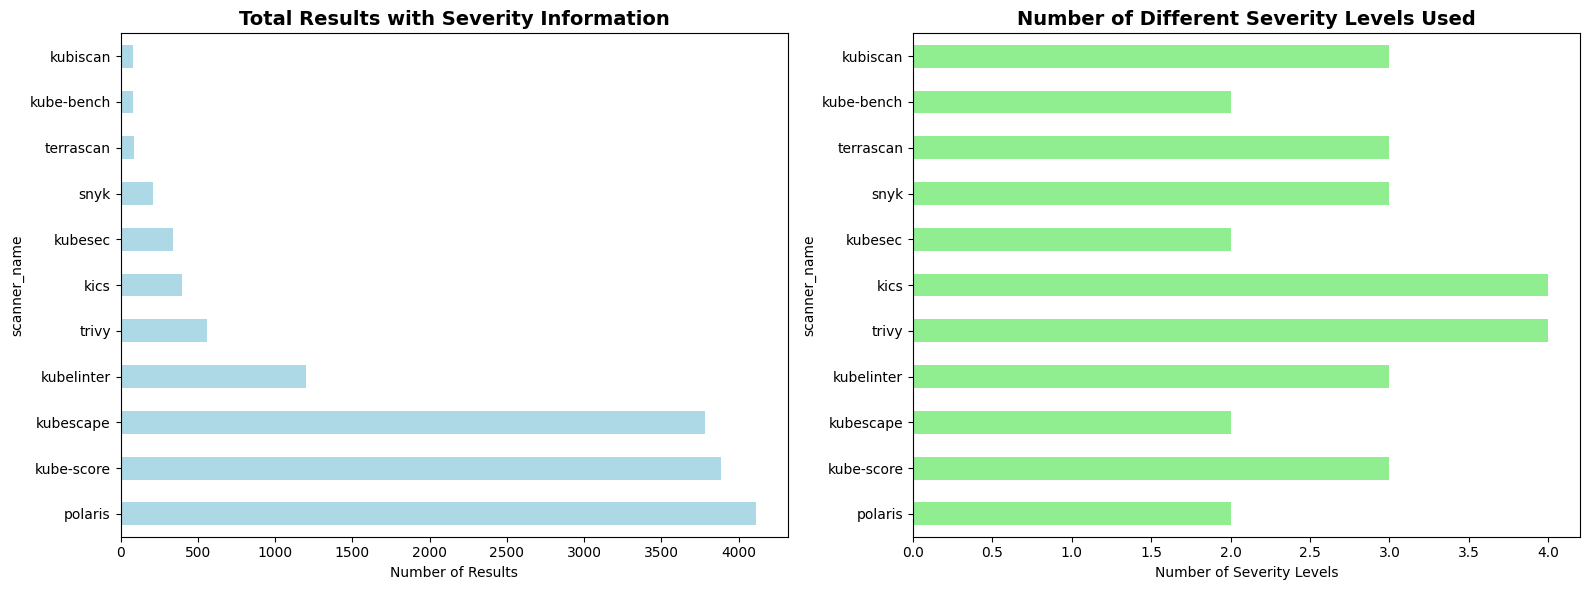

In [5]:
if len(df_results) > 0:
    # Scanner severity coverage summary
    scanner_coverage = df_results.groupby('scanner_name').agg({
        'severity': 'count',
        'severity_category': ['nunique', lambda x: x.value_counts().to_dict()],
        'scanner_check_id': 'nunique'
    }).round(2)
    
    scanner_coverage.columns = ['total_with_severity', 'severity_levels_used', 'severity_distribution', 'unique_checks']
    scanner_coverage = scanner_coverage.sort_values('total_with_severity', ascending=False)
    
    print("📊 Scanner Severity Coverage Summary:")
    for scanner, row in scanner_coverage.iterrows():
        total = int(row['total_with_severity'])
        levels = int(row['severity_levels_used']) 
        checks = int(row['unique_checks'])
        print(f"   {scanner}: {total:,} results, {levels} severity levels, {checks} unique checks")
        
    # Visualize scanner coverage
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Total results with severity
    scanner_coverage['total_with_severity'].plot(kind='barh', ax=ax1, color='lightblue')
    ax1.set_title('Total Results with Severity Information', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Number of Results')
    
    # Number of severity levels used
    scanner_coverage['severity_levels_used'].plot(kind='barh', ax=ax2, color='lightgreen')
    ax2.set_title('Number of Different Severity Levels Used', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Number of Severity Levels')
    
    plt.tight_layout()
    plt.show()

## 3. Severity Distribution Across Scanners

Compare how different scanners distribute severity ratings across the normalized scale.

📊 Severity Distribution by Scanner (Normalized):
severity_category  CRITICAL  HIGH  MEDIUM   LOW  INFO  PASS
scanner_name                                               
kics                   0.00  0.08    0.24  0.67   0.0  0.00
kube-bench             0.00  0.43    0.57  0.00   0.0  0.00
kube-score             0.04  0.00    0.00  0.00   0.0  0.95
kubelinter             0.00  0.01    0.62  0.37   0.0  0.00
kubescape              0.00  0.19    0.81  0.00   0.0  0.00
kubesec                0.00  0.44    0.00  0.56   0.0  0.00
kubiscan               0.62  0.36    0.00  0.01   0.0  0.00
polaris                0.00  0.36    0.64  0.00   0.0  0.00
snyk                   0.00  0.06    0.13  0.81   0.0  0.00
terrascan              0.00  0.20    0.49  0.31   0.0  0.00
trivy                  0.02  0.04    0.11  0.83   0.0  0.00


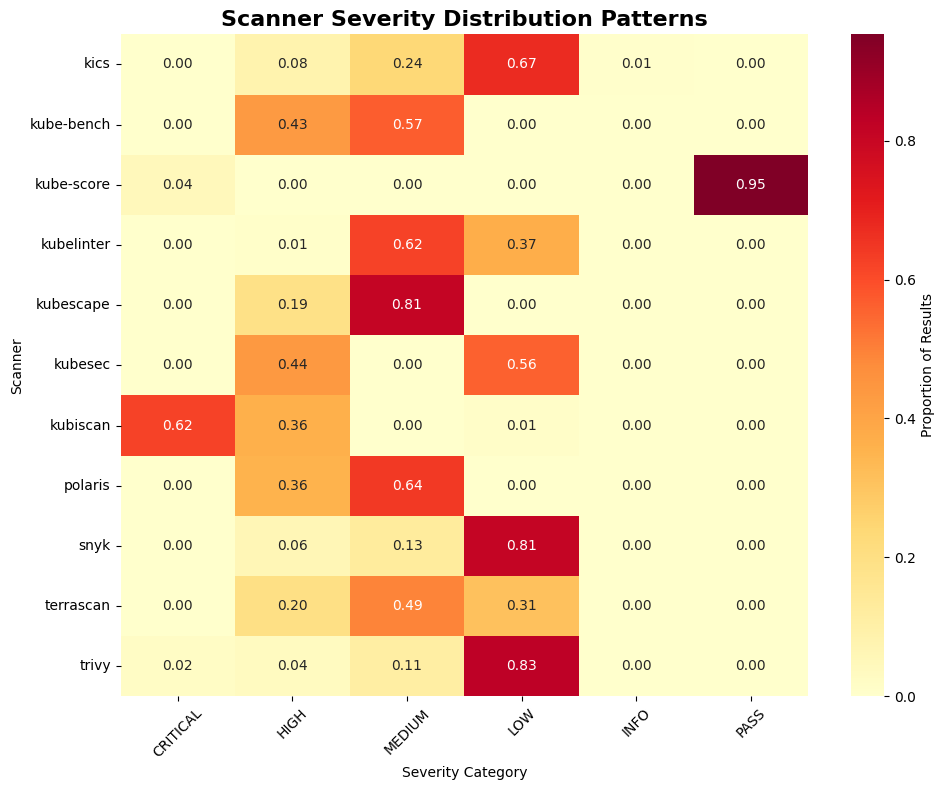


🎯 Scanner Severity Patterns:
   kics: Primarily LOW (67.4% of results)
   kube-bench: Primarily MEDIUM (56.8% of results)
   kube-score: Primarily PASS (95.3% of results)
   kubelinter: Primarily MEDIUM (62.2% of results)
   kubescape: Primarily MEDIUM (81.0% of results)
   kubesec: Primarily LOW (56.1% of results)
   kubiscan: Primarily CRITICAL (62.5% of results)
   polaris: Primarily MEDIUM (64.3% of results)
   snyk: Primarily LOW (80.8% of results)
   terrascan: Primarily MEDIUM (49.4% of results)
   trivy: Primarily LOW (82.9% of results)


In [6]:
if len(df_results) > 0:
    # Create severity distribution matrix
    severity_matrix = pd.crosstab(
        df_results['scanner_name'], 
        df_results['severity_category'], 
        normalize='index'
    ).round(3)
    
    # Ensure all severity categories are present
    for cat in ['CRITICAL', 'HIGH', 'MEDIUM', 'LOW', 'INFO', 'PASS']:
        if cat not in severity_matrix.columns:
            severity_matrix[cat] = 0
    
    # Reorder columns by severity level
    severity_order = ['CRITICAL', 'HIGH', 'MEDIUM', 'LOW', 'INFO', 'PASS']
    severity_matrix = severity_matrix.reindex(columns=[c for c in severity_order if c in severity_matrix.columns])
    
    print("📊 Severity Distribution by Scanner (Normalized):")
    print(severity_matrix.round(2))
    
    # Visualize severity distribution heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        severity_matrix, 
        annot=True, 
        fmt='.2f', 
        cmap='YlOrRd', 
        ax=ax,
        cbar_kws={'label': 'Proportion of Results'}
    )
    ax.set_title('Scanner Severity Distribution Patterns', fontsize=16, fontweight='bold')
    ax.set_xlabel('Severity Category')
    ax.set_ylabel('Scanner')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Identify scanner severity patterns
    print("\n🎯 Scanner Severity Patterns:")
    for scanner, row in severity_matrix.iterrows():
        max_category = row.idxmax()
        max_percentage = row.max() * 100
        print(f"   {scanner}: Primarily {max_category} ({max_percentage:.1f}% of results)")

## 4. Cross-Scanner Severity Agreement Analysis

Identify cases where multiple scanners detect the same issues and compare their severity assignments.

In [7]:
if len(df_results) > 0:
    # Find overlapping detections based on object and security concern patterns
    def extract_security_concern(obj_name: str, check_name: str) -> str:
        """Extract the underlying security concern from object name and check"""
        if pd.isna(obj_name) or pd.isna(check_name):
            return "unknown"
            
        # Extract base concern from object name (remove variant suffixes)
        base_name = obj_name.lower()
        
        # Map to security concerns
        if 'privileged' in base_name:
            return 'privileged-containers'
        elif 'hostpid' in base_name or 'hostipc' in base_name or 'hostnetwork' in base_name:
            return 'host-access'
        elif 'root' in base_name or 'runasuser' in base_name:
            return 'root-user'
        elif 'secret' in base_name or 'sensitive' in base_name:
            return 'secret-exposure'
        elif 'rbac' in base_name or 'cluster-admin' in base_name:
            return 'rbac-permissions'
        elif 'capability' in base_name:
            return 'dangerous-capabilities'
        elif 'network-policy' in base_name:
            return 'network-isolation'
        elif 'resource' in base_name or 'memory' in base_name or 'cpu' in base_name:
            return 'resource-limits'
        elif 'apparmor' in base_name or 'seccomp' in base_name:
            return 'security-profiles'
        else:
            return 'other'
    
    # Add security concern classification
    df_results['security_concern'] = df_results.apply(
        lambda row: extract_security_concern(row['obj_name'], row['scanner_check_name']), axis=1
    )
    
    # Find cases where multiple scanners detect the same concern
    concern_overlap = df_results.groupby(['security_concern', 'obj_name']).agg({
        'scanner_name': lambda x: list(x.unique()),
        'severity_category': lambda x: list(x.unique()),
        'severity_numeric': lambda x: list(x.unique())
    }).reset_index()
    
    # Filter for cases with multiple scanners
    multi_scanner_cases = concern_overlap[concern_overlap['scanner_name'].apply(len) > 1]
    
    print(f"🔍 Found {len(multi_scanner_cases)} cases where multiple scanners detect the same security concern")
    
    if len(multi_scanner_cases) > 0:
        print("\n📊 Multi-Scanner Detection Examples:")
        for _, case in multi_scanner_cases.head(5).iterrows():
            scanners = ', '.join(case['scanner_name'])
            severities = ', '.join(set(case['severity_category']))
            concern = case['security_concern']
            obj = case['obj_name']
            print(f"   {concern} ({obj}): {scanners} → Severities: {severities}")

🔍 Found 173 cases where multiple scanners detect the same security concern

📊 Multi-Scanner Detection Examples:
   dangerous-capabilities (pod-034-1-using-dangerous-capability-all): kube-score, kubescape, polaris, snyk, trivy → Severities: LOW, PASS, MEDIUM, HIGH, CRITICAL
   dangerous-capabilities (pod-034-2-using-dangerous-capability-sys-admin): kube-score, kubescape, polaris, snyk, trivy → Severities: LOW, PASS, MEDIUM, HIGH, CRITICAL
   dangerous-capabilities (pod-034-3-using-dangerous-capability-net-admin): kube-score, kubescape, polaris, snyk, trivy → Severities: LOW, PASS, MEDIUM, HIGH, CRITICAL
   dangerous-capabilities (pod-035-1-using-insecure-capability-audit-write): kube-score, kubescape, polaris, snyk, trivy → Severities: LOW, PASS, MEDIUM, HIGH, CRITICAL
   dangerous-capabilities (pod-035-10-using-insecure-capability-mknod): kube-score, kubescape, polaris, snyk, trivy → Severities: LOW, PASS, MEDIUM, HIGH, CRITICAL


## 5. Severity Agreement Matrix

Analyze how often scanners agree on severity levels for the same types of security issues.

🎯 Severity Agreement by Security Concern:
   dangerous-capabilities: 0% agreement (24 cases, avg range: 5.0)
   host-access: 0% agreement (6 cases, avg range: 5.0)
   network-isolation: 0% agreement (4 cases, avg range: 4.2)
   other: 0% agreement (78 cases, avg range: 4.9)
   privileged-containers: 0% agreement (4 cases, avg range: 4.5)
   rbac-permissions: 50% agreement (14 cases, avg range: 0.5)
   resource-limits: 0% agreement (16 cases, avg range: 4.5)
   root-user: 0% agreement (14 cases, avg range: 5.0)
   secret-exposure: 38% agreement (8 cases, avg range: 1.1)
   security-profiles: 0% agreement (2 cases, avg range: 5.0)
   unknown: 0% agreement (3 cases, avg range: 1.7)


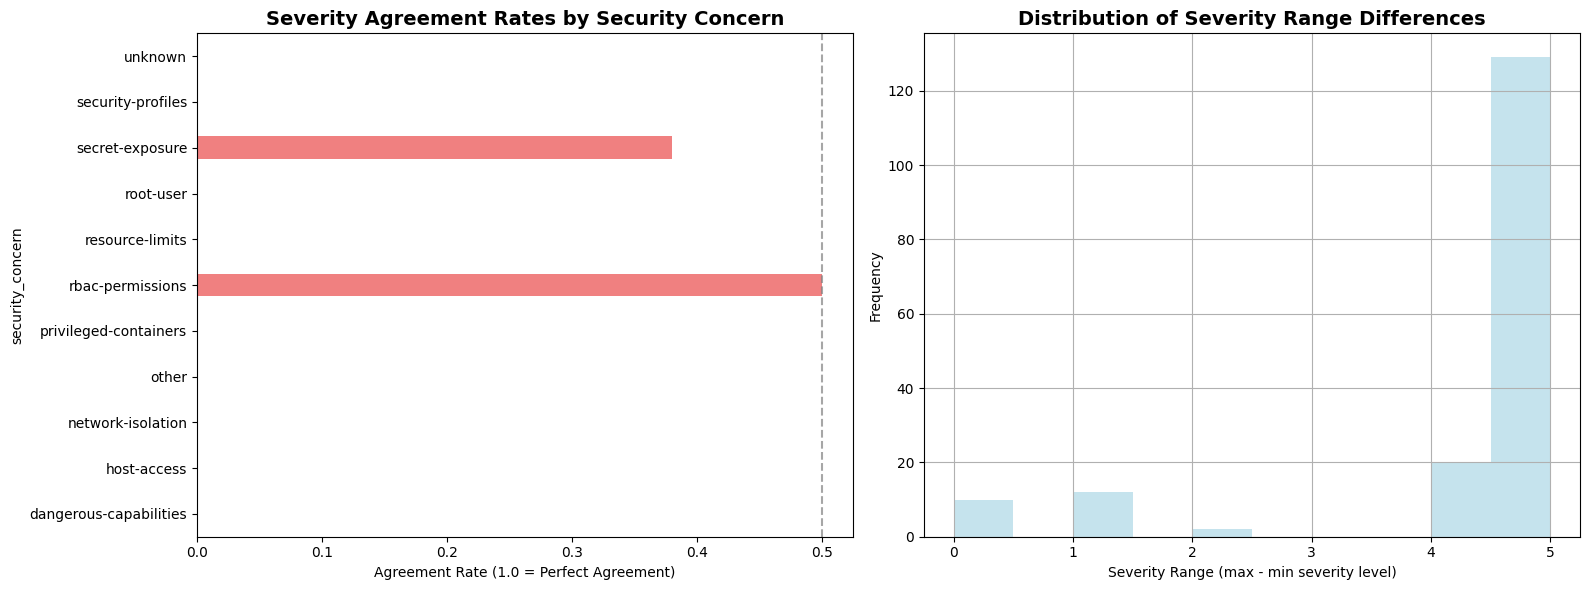

In [8]:
if len(df_results) > 0 and len(multi_scanner_cases) > 0:
    # Calculate severity agreement patterns
    def calculate_agreement_score(severities: list) -> float:
        """Calculate agreement score for a list of severity categories"""
        if len(severities) <= 1:
            return 1.0
        unique_severities = set(severities)
        return 1.0 if len(unique_severities) == 1 else len(unique_severities) / len(severities)
    
    # Analyze agreement by security concern
    agreement_analysis = multi_scanner_cases.copy()
    agreement_analysis['num_scanners'] = agreement_analysis['scanner_name'].apply(len)
    agreement_analysis['num_unique_severities'] = agreement_analysis['severity_category'].apply(lambda x: len(set(x)))
    agreement_analysis['perfect_agreement'] = agreement_analysis['num_unique_severities'] == 1
    agreement_analysis['severity_range'] = agreement_analysis['severity_numeric'].apply(
        lambda x: max(x) - min(x) if len(x) > 1 else 0
    )
    
    # Summary by security concern
    concern_agreement = agreement_analysis.groupby('security_concern').agg({
        'perfect_agreement': ['count', 'sum'],
        'severity_range': 'mean',
        'num_scanners': 'mean'
    }).round(2)
    
    concern_agreement.columns = ['total_cases', 'perfect_agreements', 'avg_severity_range', 'avg_scanners']
    concern_agreement['agreement_rate'] = (concern_agreement['perfect_agreements'] / concern_agreement['total_cases']).round(2)
    
    print("🎯 Severity Agreement by Security Concern:")
    for concern, row in concern_agreement.iterrows():
        if row['total_cases'] >= 2:  # Only show concerns with enough data
            agreement_pct = row['agreement_rate'] * 100
            avg_range = row['avg_severity_range']
            total = int(row['total_cases'])
            print(f"   {concern}: {agreement_pct:.0f}% agreement ({total} cases, avg range: {avg_range:.1f})")
    
    # Visualize agreement patterns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Agreement rates by concern
    significant_concerns = concern_agreement[concern_agreement['total_cases'] >= 2]
    significant_concerns['agreement_rate'].plot(kind='barh', ax=ax1, color='lightcoral')
    ax1.set_title('Severity Agreement Rates by Security Concern', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Agreement Rate (1.0 = Perfect Agreement)')
    ax1.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, label='50% threshold')
    
    # Severity range distribution
    agreement_analysis['severity_range'].hist(bins=10, ax=ax2, color='lightblue', alpha=0.7)
    ax2.set_title('Distribution of Severity Range Differences', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Severity Range (max - min severity level)')
    ax2.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

## 6. Scanner Reliability Analysis

Identify which scanners are most consistent and reliable for severity assessment.

🏆 Scanner Reliability Rankings:

(Reliability = 60% consistency + 40% severity coverage)
   trivy: 0.770 (consistency: 0.617, coverage: 1.000, n=561)
   kics: 0.764 (consistency: 0.606, coverage: 1.000, n=399)
   kubelinter: 0.700 (consistency: 0.667, coverage: 0.750, n=1199)
   kubiscan: 0.685 (consistency: 0.641, coverage: 0.750, n=80)
   snyk: 0.685 (consistency: 0.641, coverage: 0.750, n=208)
   terrascan: 0.651 (consistency: 0.585, coverage: 0.750, n=87)
   kubescape: 0.631 (consistency: 0.719, coverage: 0.500, n=3781)
   polaris: 0.606 (consistency: 0.676, coverage: 0.500, n=4110)
   kube-bench: 0.600 (consistency: 0.667, coverage: 0.500, n=81)
   kube-score: 0.594 (consistency: 0.490, coverage: 0.750, n=3888)
   kubesec: 0.502 (consistency: 0.503, coverage: 0.500, n=337)


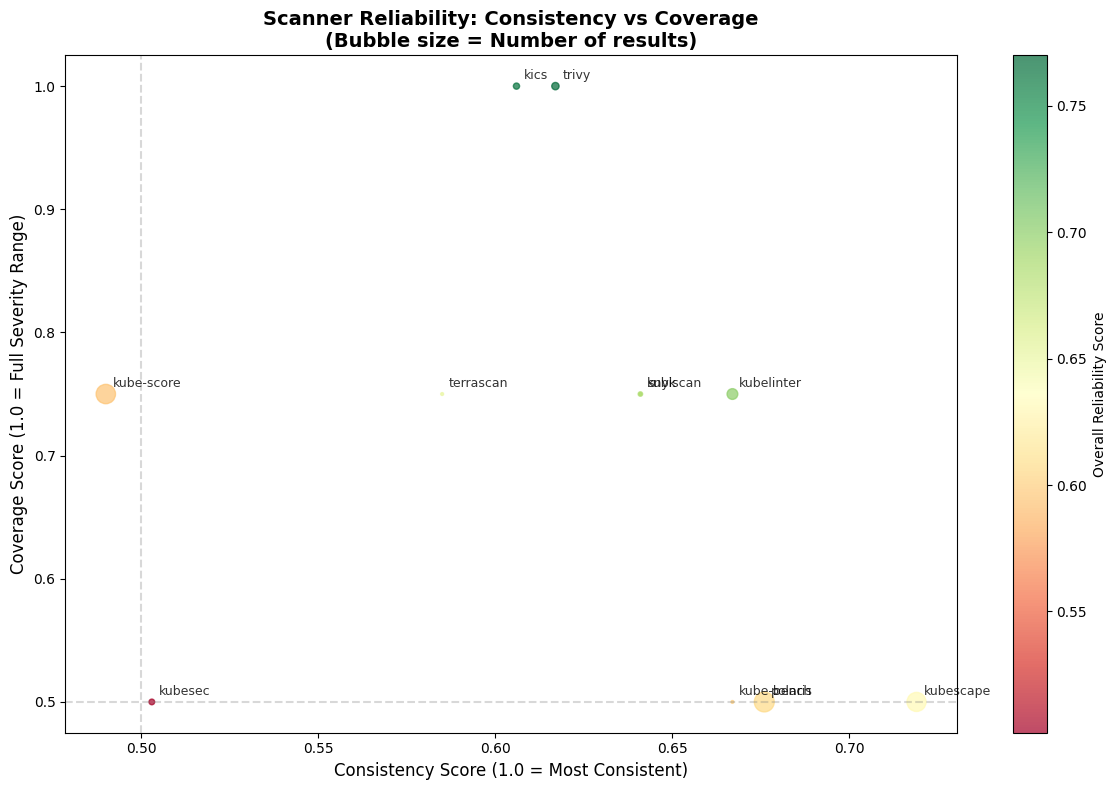

In [ ]:
if len(df_results) > 0:
    # Calculate scanner reliability metrics
    scanner_reliability = df_results.groupby('scanner_name').agg({
        'severity_numeric': ['std', 'mean', 'count'],
        'severity_category': 'nunique'
    }).round(2)
    
    scanner_reliability.columns = ['severity_std', 'severity_mean', 'total_results', 'unique_categories']
    
    # Calculate consistency score (lower std = more consistent)
    scanner_reliability['consistency_score'] = (1 / (1 + scanner_reliability['severity_std'])).round(3)
    
    # Calculate coverage score (more categories = better coverage)
    max_categories = scanner_reliability['unique_categories'].max()
    scanner_reliability['coverage_score'] = (scanner_reliability['unique_categories'] / max_categories).round(3)
    
    # Combined reliability score
    scanner_reliability['reliability_score'] = (
        (scanner_reliability['consistency_score'] * 0.6) + 
        (scanner_reliability['coverage_score'] * 0.4)
    ).round(3)
    
    scanner_reliability = scanner_reliability.sort_values('reliability_score', ascending=False)
    
    print("Scanner Reliability Rankings:")
    print("\n(Reliability = 60% consistency + 40% severity coverage)")
    for scanner, row in scanner_reliability.iterrows():
        reliability = row['reliability_score']
        consistency = row['consistency_score']
        coverage = row['coverage_score']
        total = int(row['total_results'])
        print(f"   {scanner}: {reliability:.3f} (consistency: {consistency:.3f}, coverage: {coverage:.3f}, n={total})")
    
    # Visualize reliability metrics
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Scatter plot: consistency vs coverage
    scatter = ax.scatter(
        scanner_reliability['consistency_score'],
        scanner_reliability['coverage_score'],
        s=scanner_reliability['total_results']/20,  # Size by number of results
        c=scanner_reliability['reliability_score'],
        cmap='RdYlGn',
        alpha=0.7
    )
    
    # Add scanner labels
    for scanner, row in scanner_reliability.iterrows():
        ax.annotate(
            scanner,
            (row['consistency_score'], row['coverage_score']),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=9,
            alpha=0.8
        )
    
    ax.set_xlabel('Consistency Score (1.0 = Most Consistent)', fontsize=12)
    ax.set_ylabel('Coverage Score (1.0 = Full Severity Range)', fontsize=12)
    ax.set_title('Scanner Reliability: Consistency vs Coverage\n(Bubble size = Number of results)', fontsize=14, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Overall Reliability Score', fontsize=10)
    
    # Add quadrant lines
    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.3)
    ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 7. Practical Recommendations

Generate actionable insights for using multiple scanners and interpreting severity information.

In [ ]:
if len(df_results) > 0:
    print("🎯 PRACTICAL RECOMMENDATIONS FOR MULTI-SCANNER SEVERITY ANALYSIS")
    print("="*80)
    
    # 1. Best scanners for severity reliability
    top_reliable_scanners = scanner_reliability.head(3).index.tolist()
    print("\n MOST RELIABLE SCANNERS FOR SEVERITY ASSESSMENT:")
    for i, scanner in enumerate(top_reliable_scanners, 1):
        score = scanner_reliability.loc[scanner, 'reliability_score']
        print(f"   {i}. {scanner} (reliability: {score:.3f})")
    
    # 2. High-agreement security concerns
    if 'concern_agreement' in locals() and len(concern_agreement) > 0:
        high_agreement_concerns = concern_agreement[concern_agreement['agreement_rate'] >= 0.7]
        if len(high_agreement_concerns) > 0:
            print("\n SECURITY CONCERNS WITH HIGH SCANNER AGREEMENT (≥70%):")
            for concern, row in high_agreement_concerns.iterrows():
                agreement_pct = row['agreement_rate'] * 100
                print(f"   • {concern}: {agreement_pct:.0f}% agreement")
        else:
            print("\n SECURITY CONCERNS: Limited agreement data available")
    
    # 3. Severity distribution insights
    print("\n SEVERITY DISTRIBUTION INSIGHTS:")
    overall_distribution = df_results['severity_category'].value_counts(normalize=True).round(3)
    for severity, proportion in overall_distribution.items():
        percentage = proportion * 100
        print(f"   • {severity}: {percentage:.1f}% of all findings")
    
    # 4. Scanner-specific recommendations
    print("\n SCANNER-SPECIFIC SEVERITY PATTERNS:")
    for scanner, row in severity_matrix.iterrows():
        dominant_category = row.idxmax()
        dominant_percentage = row.max() * 100
        if dominant_percentage > 50:
            print(f"   • {scanner}: Tends toward {dominant_category} severity ({dominant_percentage:.0f}%)")
    
    # 5. Coverage gaps
    print("\n COVERAGE RECOMMENDATIONS:")
    if 'scanner_coverage' in locals():
        low_coverage_scanners = scanner_coverage[scanner_coverage['severity_levels_used'] <= 2].index.tolist()
        if low_coverage_scanners:
            print(f"   • Scanners with limited severity range: {', '.join(low_coverage_scanners)}")
            print(f"   • Consider supplementing with more comprehensive severity scanners")
    
    print("\n BEST PRACTICES:")
    print("   • Use multiple scanners for comprehensive coverage")
    print("   • Prioritize findings where multiple scanners agree on HIGH/CRITICAL severity")
    print("   • For conflicting severity assessments, defer to most reliable scanners")
    print("   • Establish severity normalization rules for your organization")
    print("   • Consider context and business impact alongside scanner severity ratings")

🎯 PRACTICAL RECOMMENDATIONS FOR MULTI-SCANNER SEVERITY ANALYSIS

1️⃣ MOST RELIABLE SCANNERS FOR SEVERITY ASSESSMENT:
   1. trivy (reliability: 0.770)
   2. kics (reliability: 0.764)
   3. kubelinter (reliability: 0.700)

2️⃣ SECURITY CONCERNS: Limited agreement data available

3️⃣ SEVERITY DISTRIBUTION INSIGHTS:
   • MEDIUM: 45.7% of all findings
   • PASS: 25.2% of all findings
   • HIGH: 16.9% of all findings
   • LOW: 10.6% of all findings
   • CRITICAL: 1.6% of all findings
   • INFO: 0.0% of all findings

4️⃣ SCANNER-SPECIFIC SEVERITY PATTERNS:
   • kics: Tends toward LOW severity (67%)
   • kube-bench: Tends toward MEDIUM severity (57%)
   • kube-score: Tends toward PASS severity (95%)
   • kubelinter: Tends toward MEDIUM severity (62%)
   • kubescape: Tends toward MEDIUM severity (81%)
   • kubesec: Tends toward LOW severity (56%)
   • kubiscan: Tends toward CRITICAL severity (62%)
   • polaris: Tends toward MEDIUM severity (64%)
   • snyk: Tends toward LOW severity (81%)
   • t

## 8. Export Severity Analysis Results

Save analysis results for further investigation and reporting.

In [11]:
if len(df_results) > 0:
    # Create output directory
    output_dir = Path('../data/severity_analysis')
    output_dir.mkdir(exist_ok=True)
    
    # Export key analysis datasets
    exports = {
        'scanner_severity_coverage.csv': scanner_coverage if 'scanner_coverage' in locals() else pd.DataFrame(),
        'severity_distribution_matrix.csv': severity_matrix if 'severity_matrix' in locals() else pd.DataFrame(),
        'scanner_reliability_scores.csv': scanner_reliability if 'scanner_reliability' in locals() else pd.DataFrame(),
        'multi_scanner_detections.csv': multi_scanner_cases if 'multi_scanner_cases' in locals() else pd.DataFrame(),
        'severity_normalized_results.csv': df_results[['scanner_name', 'scanner_check_id', 'obj_name', 'severity', 'severity_category', 'severity_numeric', 'security_concern']]
    }
    
    # Save exports
    for filename, data in exports.items():
        if len(data) > 0:
            data.to_csv(output_dir / filename)
            print(f"💾 Saved: {filename} ({len(data)} rows)")
    
    # Generate summary report
    summary_report = f"""
# KALM Severity Comparison Analysis Summary
Generated: {pd.Timestamp.now()}

## Dataset Overview
- Total scanner results with severity: {len(df_results):,}
- Scanners analyzed: {df_results['scanner_name'].nunique()}
- Unique security concerns: {df_results['security_concern'].nunique()}
- Severity categories identified: {df_results['severity_category'].nunique()}

## Top Reliable Scanners
{chr(10).join([f"{i}. {scanner} (score: {scanner_reliability.loc[scanner, 'reliability_score']:.3f})" for i, scanner in enumerate(scanner_reliability.head(3).index, 1)])}

## Severity Distribution
{chr(10).join([f"- {sev}: {prop*100:.1f}%" for sev, prop in df_results['severity_category'].value_counts(normalize=True).items()])}

## Key Findings
- Scanner reliability varies significantly across tools
- Severity agreement depends on security concern type
- Some scanners show bias toward specific severity levels
- Multi-scanner approach recommended for comprehensive assessment
"""
    
    with open(output_dir / 'analysis_summary.md', 'w') as f:
        f.write(summary_report)
    
    print(f"\n📄 Analysis complete! Results saved to: {output_dir}")
    print(f"📊 Files exported: {len([f for f in exports.values() if len(f) > 0])} datasets")
else:
    print("⚠️  No scanner results with severity data found. Run scanners first to enable analysis.")

💾 Saved: scanner_severity_coverage.csv (11 rows)
💾 Saved: severity_distribution_matrix.csv (11 rows)
💾 Saved: scanner_reliability_scores.csv (11 rows)
💾 Saved: multi_scanner_detections.csv (173 rows)
💾 Saved: severity_normalized_results.csv (14731 rows)

📄 Analysis complete! Results saved to: ../data/severity_analysis
📊 Files exported: 5 datasets


## Summary

This analysis provides comprehensive insights into scanner severity patterns:

### Key Findings:
- **Scanner Reliability** varies significantly - some are more consistent in severity assignments
- **Severity Distribution** differs across scanners, with some biased toward specific levels
- **Agreement Rates** depend on security concern type - some vulnerabilities have clearer severity consensus
- **Coverage Gaps** exist where scanners don't provide severity or use limited ranges

### Practical Applications:
- **Multi-Scanner Strategy**: Use multiple scanners for comprehensive severity assessment
- **Reliability Weighting**: Trust more reliable scanners for severity decisions
- **Consensus Building**: Prioritize findings where multiple scanners agree on high severity
- **Organizational Standards**: Establish severity normalization rules based on these insights

This analysis enables data-driven decisions about scanner selection, severity interpretation, and security prioritization workflows.